In [2]:
import glob
import os

import numpy as np
from PIL import Image 
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
with open("../categories.txt", "r") as f:
    classes = [line.strip().replace(' ', '_') for line in f.readlines()]

In [4]:

def load_quickdraw_data(root, vfold_ratio=0.1, max_items_per_class=50000, img_size=(28, 28)):
    """
    Load QuickDraw data from .npy files, process images, and split into train/val sets.

    Parameters:
        root (str): Path to the directory containing QuickDraw .npy files.
        vfold_ratio (float): Fraction of the data to use as validation.
        max_items_per_class (int): Maximum number of items to load per class.
        img_size (tuple): Size to reshape images (28, 28 for QuickDraw).

    Returns:
        (torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor): Train and validation images and labels.
    """
    all_files = glob.glob(os.path.join(root, '*.npy'))
    num_classes = len(all_files)
    
    # Pre-allocate arrays based on max_items_per_class
    x = np.empty((num_classes * max_items_per_class, img_size[0] * img_size[1]), dtype=np.uint8)
    y = np.empty((num_classes * max_items_per_class,), dtype=np.int64)
    
    current_index = 0

    # Load and process each class file
    for idx, file in enumerate(all_files):
        data = np.load(file, mmap_mode='r')[:max_items_per_class, :].astype(np.uint8)
        num_samples = data.shape[0]

        # Place data in the pre-allocated arrays
        x[current_index:current_index + num_samples] = data
        y[current_index:current_index + num_samples] = idx
        current_index += num_samples

    # Trim x and y to the actual number of samples loaded
    x = x[:current_index]
    y = y[:current_index]

    # Shuffle the dataset
    indices = np.random.permutation(len(y))
    x = x[indices]
    y = y[indices]

    # Reshape images and normalize
    x = x.reshape(-1, *img_size)

    # Split dataset into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=vfold_ratio, random_state=42)

    return x_train, x_val, y_train, y_val


In [5]:
class QuickDrawDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28)  # Reshape to original 2D image
        label = self.labels[idx]

        # Convert to PIL for torchvision transforms
        image = Image.fromarray(image, mode="L")
        
        if self.transform:
            image = self.transform(image)

        return image, label
    
# Apply transforms for resizing and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
])


# Assume data is loaded from a .npy file or similar format
X_train, X_val, y_train, y_val = load_quickdraw_data('../data', vfold_ratio=0.1, max_items_per_class=1000)

train_dataset = QuickDrawDataset(X_train, y_train, transform=transform)
val_dataset = QuickDrawDataset(X_val, y_val, transform=transform)

In [6]:
class Ink2DoodleNet(nn.Module):
    def __init__(self, num_classes=345):
        super(Ink2DoodleNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.1),

            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64),nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64),nn.ReLU(),
            nn.MaxPool2d(2), nn.Dropout(0.1)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*3*3, 512), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [7]:
# Set up DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

In [8]:

# def load_and_save_ink2doodle_weights(checkpoint_path, model_class, num_classes, lr=0.001, save_path="ink2doodle_converted_weights.pth"):
#     # Initialize the base model class
#     model = model_class(num_classes=num_classes)
    
#     # Load checkpoint into memory
#     checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=True)

#     # Strip "model." prefix from the keys in the state_dict
#     adjusted_state_dict = {k.replace("model.", ""): v for k, v in checkpoint['state_dict'].items()}
    
#     # Load adjusted state_dict into the model
#     model.load_state_dict(adjusted_state_dict, strict=True)
    
#     # Save the adjusted state dict
#     torch.save(model.state_dict(), save_path)
#     print(f"Converted weights saved to {save_path}")
    
#     return model

# # Load, adjust, and save the checkpoint for Ink2DoodleNet
# checkpoint_path = r"D:\masters-ml-projects\Fundamentals of Computer Vision\DoodleClassifier\ink2doodle\models\ink2doodle.ckpt"
# save_path = r"D:\masters-ml-projects\Fundamentals of Computer Vision\DoodleClassifier\ink2doodle\models\ink2doodle_converted_weights.pth"
# model = load_and_save_ink2doodle_weights(checkpoint_path, Ink2DoodleNet, num_classes=345, save_path=save_path)

# # Set the model to evaluation mode
# model.eval()

In [9]:
def load_ink2doodle_weights(checkpoint_path, model_class, num_classes, lr=0.001):
    # Initialize the base model class
    model = model_class(num_classes=num_classes)
    
    # Load checkpoint into memory
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    # Load adjusted state_dict into the model
    model.load_state_dict(checkpoint, strict=True)
    
    return model

# Load the checkpoint into Ink2DoodleNet
checkpoint_path = r"D:\masters-ml-projects\Fundamentals of Computer Vision\DoodleClassifier\ink2doodle\models\ink2doodle.pth"
model = load_ink2doodle_weights(checkpoint_path, Ink2DoodleNet, num_classes=345)

# Set the model to evaluation mode
model.eval()

C:\Users\balsr\AppData\Local\Temp\ipykernel_36060\291298645.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.d

Ink2DoodleNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.1, 

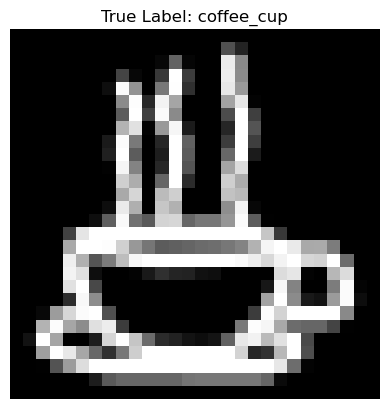

Top 5 Predictions:
1: coffee_cup (78.17%)
2: cake (9.10%)
3: birthday_cake (7.56%)
4: hot_tub (1.63%)
5: mug (1.61%)


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  

device = torch.device("cpu")
# Set the model to evaluation mode
model.eval()

# Display an example prediction
idx = randint(0, len(val_loader.dataset))
img, true_label = val_loader.dataset[idx]
img = img.unsqueeze(0).to(device)  # Add batch dimension and move to the model's device

# Show the image
plt.imshow(img.cpu().squeeze(), cmap='gray')
plt.title(f"True Label: {classes[true_label]}")
plt.axis('off')
plt.show()

# Make a prediction
with torch.no_grad():
    model.eval()
    output = model(img)
    probabilities = torch.softmax(output, dim=1)[0]
    top_5_probs, top_5_indices = torch.topk(probabilities, 5)

# Display the top 5 predictions with probabilities
print("Top 5 Predictions:")
for i in range(5):
    print(f"{i+1}: {classes[top_5_indices[i].item()]} ({top_5_probs[i].item() * 100:.2f}%)")


In [11]:
def top_k_accuracy(model, data_loader, k=5, subset_size=100):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradients for evaluation
        for idx, (images, labels) in enumerate(data_loader):
            if total >= subset_size:
                break  # Stop after reaching the subset size

            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Get model predictions
            _, top_k_preds = torch.topk(outputs, k, dim=1)  # Get the top k predictions
            top_k_preds = top_k_preds.t()  # Transpose for easy comparison
            correct += (top_k_preds == labels.view(1, -1)).any(dim=0).sum().item()  # Check if any top k is correct
            total += labels.size(0)

            # Stop early if adding this batch exceeds subset size
            if total > subset_size:
                correct -= (top_k_preds == labels.view(1, -1)).any(dim=0).sum().item()
                total -= labels.size(0)
                remaining = subset_size - total
                correct += (top_k_preds[:, :remaining] == labels.view(1, -1)[:, :remaining]).any(dim=0).sum().item()
                total += remaining
                break

    # Calculate accuracy as a percentage
    top_k_acc = (correct / total) * 100
    return top_k_acc

subset_size=1000
# Example usage with k=5 and subset_size=100
top_k_acc = top_k_accuracy(model, val_loader, k=5, subset_size=subset_size)
print(f"Top-5 Accuracy on subset of {subset_size} samples: {top_k_acc:.2f}%")


Top-5 Accuracy on subset of 1000 samples: 88.60%
